In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import histlite as hl
import csky as cy
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats

In [2]:
mpl.rcParams['font.size'] = 20

In [3]:
ana_dir = cy.utils.ensure_dir('/home/jthwaites/csky_cache')

In [4]:
ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86_2011_2018, 
                      dir=ana_dir)
cy.CONF['ana'] = ana
#ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', cy.selections.GFUDataSpecs.gfu_IC86, dir=ana_dir)

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2013_data.npy ...
Reading /data/a

In [5]:
with open('./repeaters.txt') as json_file:
    repeaters = json.load(json_file)
#print(repeaters.keys())

In [7]:
rep_source={'src':[],'coord':[],'mjd':[]}
ra=[]
dec=[]
for source in repeaters:
    rep_source['src'].append(source)
    ra.append(repeaters[source]['ra']['value'])
    dec.append(repeaters[source]['dec']['value'])
    
    times=[]
    for key in repeaters[source]:
        if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
            key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
            key!='previous_name': 
            times.append(Time(repeaters[source][key]['timestamp']['value'],format ='iso').mjd)
    rep_source['mjd'].append(times)
rep_source['coord']=SkyCoord(ra=ra,dec=dec, unit=(u.hourangle,u.deg))

In [8]:
frbs = pd.read_csv('./frbs_wout_chime.csv')
frbs.head()

,frb_name,utc,telescope,rop_raj,rop_decj,rop_gl,rop_gb,rmp_dm,rmp_width,rmp_snr,rmp_flux
0,FRB191108,2019/11/08 19:48:50.471,Apertif,01:33:47,+31:51:30,133.30,-30.100000,588.1&plusmn0.1,0.34,103.0,27.000
1,FRB121102,2012/11/02 06:35:53.244,arecibo,05:32:09,33:05:13,174.95,-0.225138,557&plusmn2,3.00,14.0,0.400
2,FRB141113,2014/11/13 07:42:55.220,arecibo,06:13:00.1,18:47:11.2,191.90,0.360000,400.3,2.00,8.4,0.039
3,FRB170107,2017/01/07 20:05:08.139,ASKAP,11:23.3,-05:00,266.10,51.400000,609.5&plusmn0.5,2.40,16.0,24.100
4,FRB170416,2017/04/16 23:11:12.799,ASKAP,22:13,-55:02,337.60,-50.000000,523.2&plusmn0.2,5.00,13.0,19.400


In [9]:
#start with one frb first, then more later: FRB121102
frbs_coord = SkyCoord(ra=frbs['rop_raj'], dec=frbs['rop_decj'], unit=(u.hourangle, u.deg))
frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbs['utc']])

#choose northern FRB: 33 deg dec for FRB121102
wn=np.where(frbs['frb_name']=='FRB121102')
#choose southern FRB: -35 deg dec for FRB180110
ws=np.where(frbs['frb_name']=='FRB180110')
frbs_coord[wn]

<SkyCoord (ICRS): (ra, dec) in deg
    [(83.0375, 33.08694444)]>

In [10]:
all_ras=[]
all_dec=[]
all_mjd=[]
for i in range(len(frbs_coord.ra)):
    all_ras.append(frbs_coord[i].ra.deg)
    all_dec.append(frbs_coord[i].dec.deg)
    all_mjd.append(frbs_mjd[i])

for i in range(len(rep_source['src'])):
    for j in range(len(rep_source['mjd'][i])):
        all_ras.append(rep_source['coord'][i].ra.deg)
        all_dec.append(rep_source['coord'][i].dec.deg)
        all_mjd.append(rep_source['mjd'][i][j])

#for i in range(len(frbs['frb_name'].values)):
#    print(frbs['frb_name'].values[i], frbs_coord[i].dec.deg)

In [11]:
#build source object
def sources(t_s): #time window (sec)
    src = cy.utils.Sources(
        ra=all_ras,
        dec=all_dec, 
        mjd=all_mjd,
        t_100=[t_s/84600.]*len(all_ras), #in mjd
        sigma_t=[0.]*len(all_ras),
        deg=True)
    return src

In [12]:
def make_frb_skymap(print_plot=False):
    dec=[d for d in frbs_coord.dec.rad]
    dec2=[d for d in rep_source['coord'].dec.rad]
    ra=[d for d in frbs_coord.ra.rad]
    ra2=[d for d in rep_source['coord'].ra.rad]
    
    src_map = hl.heal.hist(128, dec+dec2, ra+ra2)

    fig, ax = plt.subplots(figsize=(10,6),subplot_kw=dict(projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Blues',vmin=0))
    mesh, cb = sp.plot_map(ax, np.where(src_map.map>0, src_map.map, np.nan), n_ticks=2)
    kw = dict(color='.5', alpha=.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    plt.title('Skymap of FRB locations \n')
    cb.set_label(r'FRBs/bin')
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/frb_skymap.png')

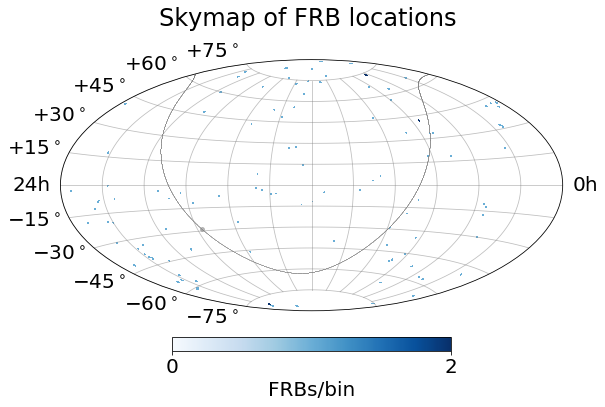

In [13]:
make_frb_skymap()

In [14]:
conf = {'extended': True,
        'space': "ps",
        'time': "transient",
        'sig': 'transient',
        }

In [15]:
def bg_ts_trials(src, n_trials=10000, frb_name = ' ', print_plot=False):
    tr=cy.get_trial_runner(conf,ana=ana,src=src)
    
    #running bg trials
    trials=tr.get_many_fits(n_trials)
    bg = cy.dists.Chi2TSD(trials)
    if np.count_nonzero(trials.ts)==0:
        print('no nonzero TS values')
    
    fig, ax = plt.subplots(figsize=(9,6))
    h = bg.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True, label='%i bg trials'%(bg.n_total))

    # compare with the chi2 fit:
    x = h.centers[0][1:] #remove zero TS bin from curve: not fitted here
    norm = h.integrate().values #normalization for chi-sq
    ax.semilogy(x, norm * bg.pdf(x), lw=1, label=r'$\chi^2$[%.2f dof, $\eta$=%.3f]'%(bg.ndof, bg.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'$N$')
    if src['t_100'][0]==1.: plt.title(r'BG TS distribution, %s (1d)'%(frb_name))
    else: plt.title(r'BG TS distribution, %s (%is)'%(frb_name,src['t_100'][0]*84600.))
    ax.legend()
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_bgts_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
    
    return bg.median() #used in calc for sens

In [38]:
def sens_times(t_100,src_ind=False):
    srcs=sources(t_100)
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind])
    trials=tr.get_many_fits(10000)
    if np.count_nonzero(trials.ts)==0: return
    
    bg = cy.dists.Chi2TSD(trials)
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs[src_ind],inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_sig_step=1, logging=False)
    
    return sens['n_sig'], sens['n_sig_error'], tr.to_E2dNdE(sens, E0=1, unit=1)

In [39]:
sens=[]
sens_err=[]
dnde=[]
for t_i in np.logspace(2,5.5,num=30):
    print('-->t=%i sec'%t_i)
    s1, s2, s3= sens_times(t_i, src_ind=wn)
    sens.append(s1)
    sens_err.append(s2)
    dnde.append(s3)

-->t=100 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=132 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=174 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=230 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=303 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=401 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=529 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=699 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=923 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
-->t=1219 sec
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   

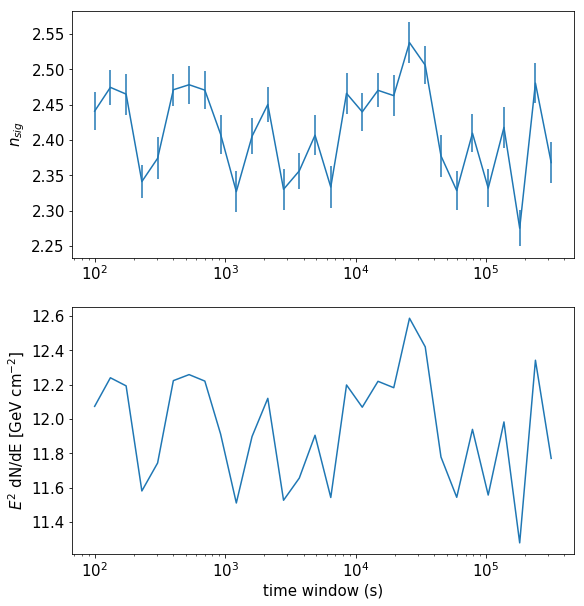

In [48]:
#prev vers
fig,axs = plt.subplots(2,figsize=(9,10))
ts=np.logspace(2,5.5,num=30)
axs[0].errorbar(ts, sens, yerr=sens_err)
axs[0].set(ylabel=r'$n_{sig}$')
axs[1].plot(np.logspace(2,5.5,num=30), dnde)
axs[1].set(ylabel=r'$E^2$ dN/dE [GeV cm$^{-2}$]')

#sens=np.array(sens)
#w=np.where(sens==min(sens[0:19]))
#axs[0].axvline(ts[w], ls='--',color='g')
#axs[1].axvline(ts[w], ls='--',color='g')

axs[0].semilogx()
#axs[0].semilogy()
axs[1].semilogx()
#axs[1].semilogy()
plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat.png'%('FRB180110'))

In [ ]:
#new vers
def deltat_plot(sens, dnde, frb_name, sav_plot=False)
    fig,axs = plt.subplots(2,figsize=(9,10))
    dt=np.logspace(2,5,num=20)
    axs[0].errorbar(dt, sens, yerr=sens_err)
    axs[0].set(ylabel=r'$n_{sig}$')
    axs[1].plot(np.logspace(2,5,num=20), dnde)
    axs[1].set(ylabel=r'$E^2$ dN/dE')

    axs[0].semilogx()
    axs[0].semilogy()
    axs[1].semilogx()
    axs[1].semilogy()
    plt.xlabel('time window (s)')
    if sav_plot==False: plt.show()
    else: plt.savefig('./plots/%s_deltat.png'%(frb_name))

In [17]:
src1d = sources(84600)
src1000 = sources(1000)
wn=np.where(frbs['frb_name']=='FRB121102')#choose northern FRB
ws=np.where(frbs['frb_name']=='FRB180110')#choose southern FRB

In [18]:
src100=sources(100)
tr=cy.get_trial_runner(conf,ana=ana,src=src100[ws])
trials=tr.get_many_fits(10000)
print(np.count_nonzero(trials.ts))

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
2


Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


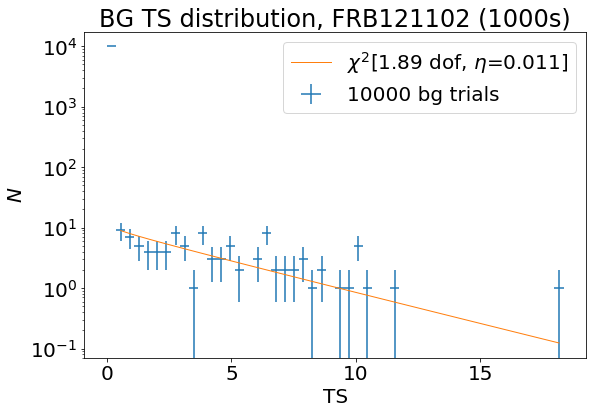

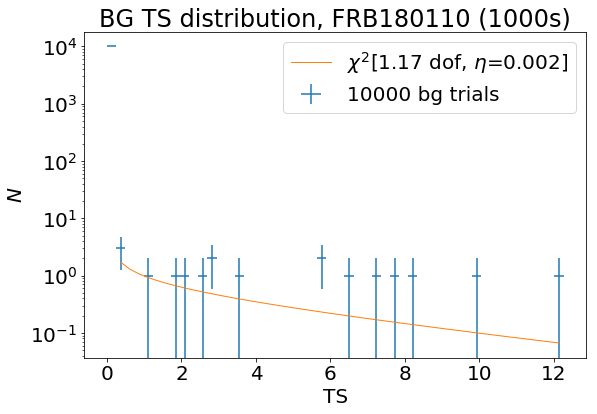

In [19]:
md_n=bg_ts_trials(src1000[wn], frb_name='FRB121102', print_plot=True)
md_s=bg_ts_trials(src1000[ws], frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


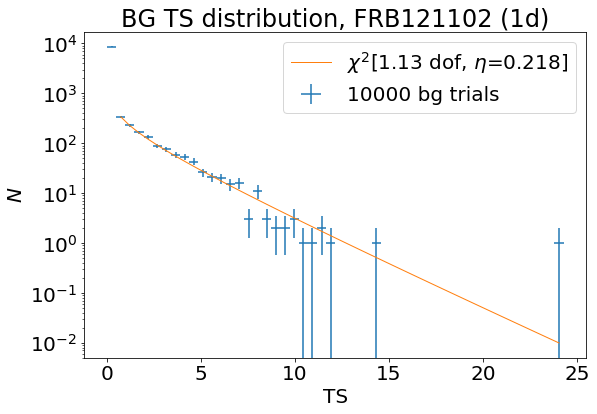

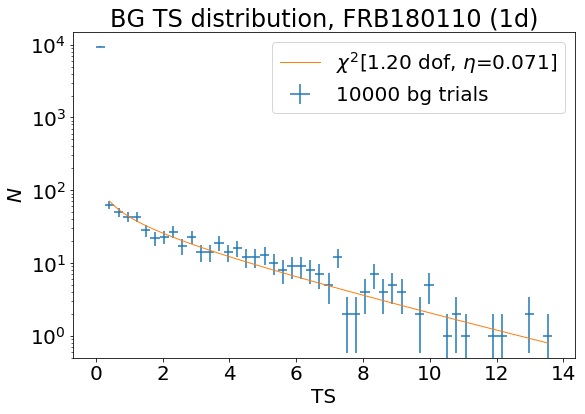

In [20]:
md_n_1d=bg_ts_trials(src1d[wn], frb_name='FRB121102', print_plot=True)
md_s_1d=bg_ts_trials(src1d[ws], frb_name='FRB180110', print_plot=True)

In [23]:
#old version
def get_sens_pf(src, median_bg_ts, frb_name=' ', print_plot=False, show_pchip=False, show_chisq=True):
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(median_bg_ts,0.9, tol=0.03,n_batches=10,n_sig_step=1)
    
    fig = plt.figure(dpi=120, figsize=(9,6))
    mpl.rcParams['font.size'] = 15
    xs = np.linspace(0., max(sens['info']['n_sigs']), 500)
    chi2cdf = lambda n: stats.chi2.cdf(n, *sens['info']['params'])
    plt.errorbar(sens['info']['n_sigs'], sens['info']['CLs'], 
             yerr=sens['info']['sigmas'], label = 'Linear')
    
    if show_pchip==True:
        plt.plot(xs, sens['info']['spline'](xs), label='PCHIP Interp.', color='g')
        plt.axvline(sens['info']['n_sig_spline'], ls='--', color='g')
    
    if show_chisq==True:
        plt.plot(xs, chi2cdf(xs), label = 'Chi2CDF')
        plt.axvline(sens['info']['n_sig_chi2cdf'], ls='--')
        
    plt.legend(loc=4)
    plt.xlabel(r'$n_{\mathrm{inj}}$')
    plt.ylabel(r'Fraction TS $>$ threshold')
    
    if int(src['t_100'][0]) == 1: 
        plt.title(r'passing fraction, %s (1d), $n_{sig}$=%.3f$\pm$%.3f'
                  %(frb_name,sens['n_sig'],sens['n_sig_error']))
    else: 
        plt.title(r'passing fraction, %s (%is), $n_{sig}$=%.3f$\pm$%.3f'
                  %(frb_name,src['t_100'][0]*84600.,sens['n_sig'],sens['n_sig_error']))
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_pf_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
        
def get_sens(src, median_bg_ts):
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(median_bg_ts,0.9, tol=0.03,n_batches=10,n_sig_step=1)
    return sens['n_sig'], sens['n_sig_error']

In [ ]:
#better version
def pf_plot(sens, frb_name=' ', print_plot=False, show_pchip=False, show_chisq=True):
    fig = plt.figure(dpi=120, figsize=(9,6))
    mpl.rcParams['font.size'] = 15
    xs = np.linspace(0., max(sens['info']['n_sigs']), 500)
    chi2cdf = lambda n: stats.chi2.cdf(n, *sens['info']['params'])
    plt.errorbar(sens['info']['n_sigs'], sens['info']['CLs'], 
             yerr=sens['info']['sigmas'], label = 'Linear')
    
    if show_pchip==True:
        plt.plot(xs, sens['info']['spline'](xs), label='PCHIP Interp.', color='g')
        plt.axvline(sens['info']['n_sig_spline'], ls='--', color='g')
    
    if show_chisq==True:
        plt.plot(xs, chi2cdf(xs), label = 'Chi2CDF')
        plt.axvline(sens['info']['n_sig_chi2cdf'], ls='--')
        
    plt.legend(loc=4)
    plt.xlabel(r'$n_{\mathrm{inj}}$')
    plt.ylabel(r'Fraction TS $>$ threshold')
    
    if int(src['t_100'][0]) == 1: 
        plt.title(r'passing fraction, %s (1d), $n_{sig}$=%.3f$\pm$%.3f'
                  %(frb_name,sens['n_sig'],sens['n_sig_error']))
    else: 
        plt.title(r'passing fraction, %s (%is), $n_{sig}$=%.3f$\pm$%.3f'
                  %(frb_name,src['t_100'][0]*84600.,sens['n_sig'],sens['n_sig_error']))
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_pf_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
        
def get_sens(src, median_bg_ts):
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    sens=tr.find_n_sig(median_bg_ts,0.9, tol=0.03,n_batches=10,n_sig_step=1)
    return sens

def get_dp(src, nsigma_threshold, beta):
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    disc = tr.find_n_sig(nsigma_threshold, beta, tol=0.03,n_batches=10,n_sig_step=1)
    return disc

Start time: 2021-05-12 09:49:52.886453
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 1.000 ... frac = 0.58000
  n_sig = 2.000 ... frac = 0.88000
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.67    1.33    2.00    2.67    3.33    4.00    4.67    5.33    6.00  |  n_sig(relative error)
50       |          0.0%   54.0%   70.0%   78.0%   94.0%   98.0%   98.0%  100.0%  100.0%  100.0%  |      2.284 (+/-  8.0%) [chi2.cdf]
100      |          0.0%   50.0%   76.0%   77.0%   94.0%   96.0%   98.0%  100.0%  100.0%   99.0%  |      2.326 (+/-  5.7%) [chi2.cdf]
150      |          0.0%   54.0%   73.3%   80.7%   92.7%   96.7%   97.3%   99.3%  100.0%   99.3%  |      2.339 (+/-  6.0%) [chi2.cdf]
200      |          0.5%   51.0%   73.5%   83.0%   92.5%   97.0%   97.0%   99.0%  100.0%   98.5%  |      2.350 (+/-  4.6%) [chi2.cdf]
250      |          0.8%   48.8%   72.8%   82.0%   92.4%   96.4%   97.2%   98.8%

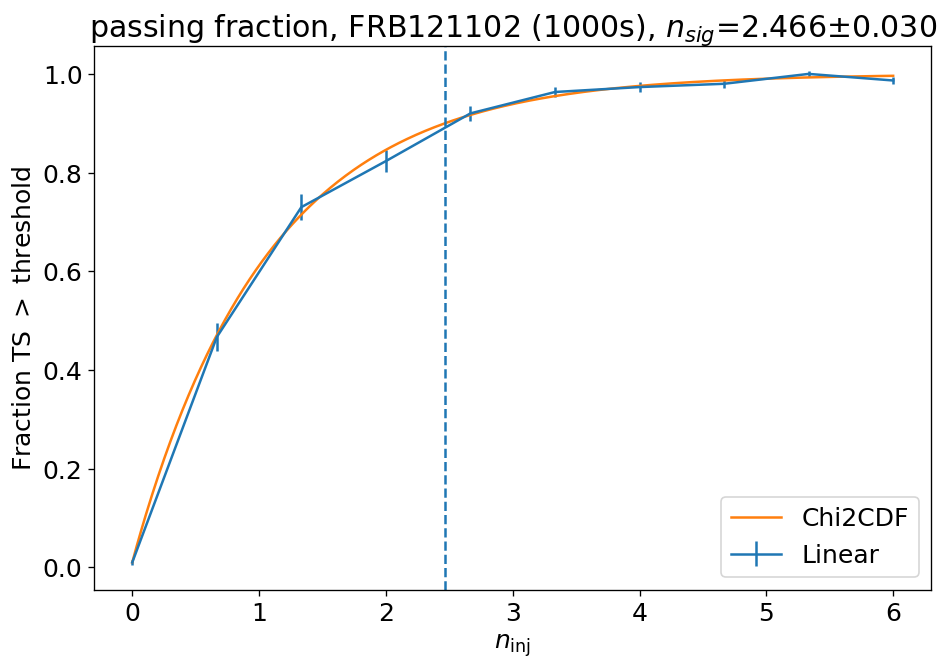

In [24]:
get_sens_pf(src1000[wn], md_n ,frb_name='FRB121102',print_plot=True)

Start time: 2021-05-12 09:50:41.782203
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 1.000 ... frac = 0.58000
  n_sig = 2.000 ... frac = 0.90000
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.44    0.89    1.33    1.78    2.22    2.67    3.11    3.56    4.00  |  n_sig(relative error)
50       |          2.0%   26.0%   56.0%   82.0%   86.0%   92.0%   96.0%   92.0%   98.0%   98.0%  |      2.048 (+/-  8.6%) [chi2.cdf]
100      |          1.0%   29.0%   57.0%   76.0%   87.0%   94.0%   93.0%   94.0%   98.0%   99.0%  |      2.088 (+/-  5.1%) [chi2.cdf]
150      |          0.7%   32.0%   56.0%   76.0%   88.0%   92.7%   93.3%   96.0%   96.0%   98.7%  |      2.130 (+/-  4.6%) [chi2.cdf]
200      |          1.0%   34.5%   54.5%   75.5%   87.5%   92.0%   93.5%   94.0%   96.0%   99.0%  |      2.181 (+/-  4.8%) [chi2.cdf]
250      |          0.8%   32.4%   54.8%   74.4%   87.2%   89.2%   92.4%   94.0%   96.0%   98.4%  |      2.296 (+/-

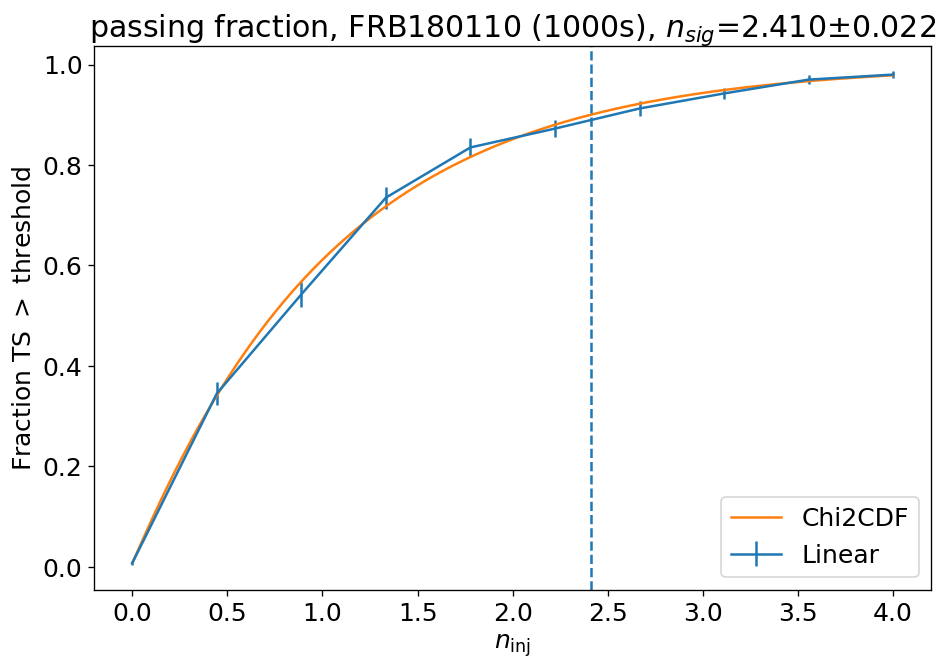

In [25]:
get_sens_pf(src1000[ws], md_s ,frb_name='FRB180110',print_plot=True)

Start time: 2021-05-12 09:51:25.691650
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 1.000 ... frac = 0.74000
  n_sig = 2.000 ... frac = 0.96000
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.44    0.89    1.33    1.78    2.22    2.67    3.11    3.56    4.00  |  n_sig(relative error)
50       |         18.0%   54.0%   58.0%   76.0%   78.0%   84.0%   96.0%   90.0%   94.0%   98.0%  |      2.439 (+/- 11.4%) [chi2.cdf]
100      |         22.0%   46.0%   66.0%   76.0%   82.0%   87.0%   92.0%   94.0%   97.0%   98.0%  |      2.378 (+/-  5.3%) [chi2.cdf]
150      |         21.3%   48.7%   62.0%   76.7%   82.7%   88.0%   94.0%   92.0%   97.3%   96.7%  |      2.348 (+/-  5.3%) [spline]
200      |         23.0%   46.5%   60.5%   78.0%   83.0%   90.0%   94.5%   92.0%   95.5%   96.5%  |      2.374 (+/-  6.4%) [chi2.cdf]
250      |         22.4%   48.4%   61.2%   79.2%   83.6%   90.8%   93.6%   90.4%   96.4%   96.8%  |      2.355 (+/-  

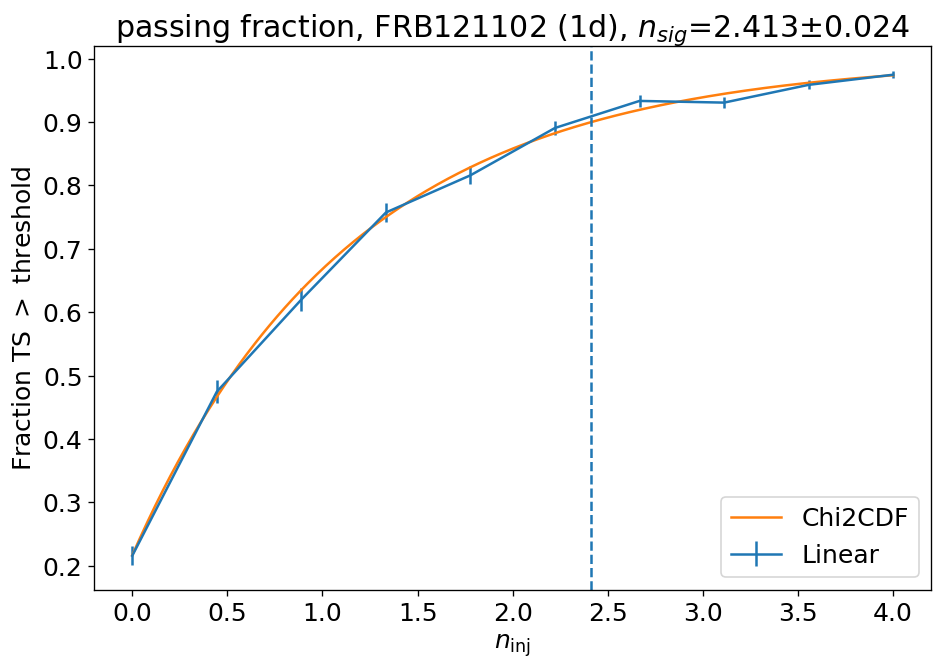

In [26]:
get_sens_pf(src1d[wn], md_n_1d ,frb_name='FRB121102',print_plot=True)

Start time: 2021-05-12 09:53:42.707173
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 1.000 ... frac = 0.68000
  n_sig = 2.000 ... frac = 0.86000
  n_sig = 3.000 ... frac = 0.98000
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.67    1.33    2.00    2.67    3.33    4.00    4.67    5.33    6.00  |  n_sig(relative error)
50       |          4.0%   62.0%   78.0%   92.0%   90.0%   98.0%   98.0%   98.0%   98.0%  100.0%  |      2.072 (+/-  9.6%) [chi2.cdf]
100      |          7.0%   62.0%   79.0%   89.0%   89.0%   98.0%   97.0%   99.0%   99.0%  100.0%  |      2.126 (+/-  6.3%) [chi2.cdf]
150      |          6.7%   62.0%   71.3%   86.0%   91.3%   98.7%   98.0%   98.7%   99.3%  100.0%  |      2.144 (+/-  5.6%) [chi2.cdf]
200      |          6.5%   59.5%   71.5%   83.5%   92.0%   99.0%   98.5%   98.5%   99.5%  100.0%  |      2.120 (+/-  4.9%) [chi2.cdf]
250      |          6.0%   56.8%   72.4%   84.0%   92.0%   98.8%   98.0%   98.8%

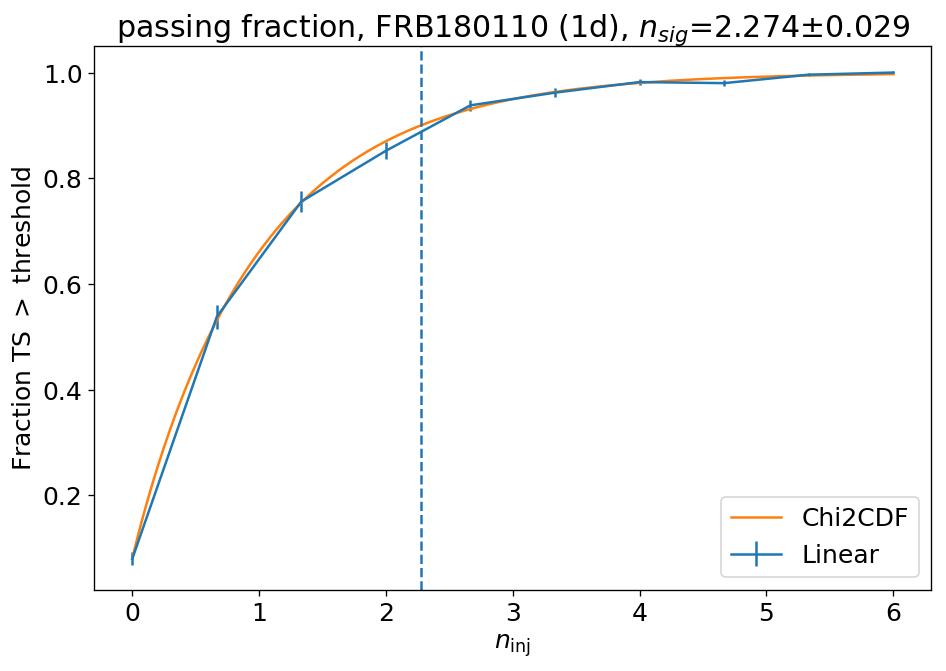

In [27]:
get_sens_pf(src1d[ws], md_s_1d ,frb_name='FRB180110',print_plot=True)

In [35]:
tr=cy.get_trial_runner(conf,ana=ana,src=src1d[ws],inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
sens=tr.find_n_sig(md_s_1d, 0.9,tol=0.03,n_batches=10,n_sig_step=1)
#tr.to_E2dNdE(sens)

Start time: 2021-05-12 09:58:41.192213
Using 1 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 1.000 ... frac = 0.70000
  n_sig = 2.000 ... frac = 0.86000
  n_sig = 3.000 ... frac = 0.92000
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.67    1.33    2.00    2.67    3.33    4.00    4.67    5.33    6.00  |  n_sig(relative error)
50       |          8.0%   46.0%   76.0%   76.0%   98.0%   98.0%   98.0%   98.0%  100.0%  100.0%  |      2.079 (+/-  9.4%) [chi2.cdf]
100      |          9.0%   48.0%   74.0%   82.0%   96.0%   97.0%   97.0%   99.0%   99.0%  100.0%  |      2.276 (+/-  6.5%) [chi2.cdf]
150      |          8.7%   50.0%   75.3%   82.0%   94.0%   96.7%   98.0%   99.3%   98.7%  100.0%  |      2.316 (+/-  4.8%) [chi2.cdf]
200      |          8.5%   49.5%   75.5%   81.5%   93.0%   96.5%   98.5%   99.0%   99.0%  100.0%  |      2.350 (+/-  3.6%) [chi2.cdf]
250      |          8.0%   48.4%   72.4%   83.6%   93.2%   96.4%   98.8%   99.2%

In [37]:
print(tr.to_E2dNdE(sens, E0=100, unit=1e3))#100 TeV cm^-2
print(tr.to_E2dNdE(sens))
print(tr.to_E2dNdE(sens, E0=1, unit=1))#GeV cm^-2

0.14472055500288922
144.72055500288923
144.72055500288923
